In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import random

# **Implementation of Decision Tree Modeling Function:**

In [12]:
def calculate_entropy(y):
    if len(y) == 0:  # Empty segment
        return 0
    counts = np.bincount(y)
    probabilities = counts / len(y)
    entropy = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    return entropy

def calculate_information_gain(y, mask, entropy):
    # Subsets for left and right branches
    left_labels = y[mask]
    right_labels = y[~mask]
    left_entropy = calculate_entropy(left_labels)
    right_entropy = calculate_entropy(right_labels)

    # Weighted average of the entropy after split
    left_weight = len(left_labels) / len(y)
    right_weight = len(right_labels) / len(y)

    # Information gain is the entropy before the split minus the weighted entropy after the split
    return entropy - left_weight * left_entropy - right_weight * right_entropy

def split_data(X, y, column_index, value, feature_type):
    # Split the data X and labels y based on the given feature and value

    # Numeric, if feature_type == 1
    if feature_type == 1:
        mask = X[:, column_index] < value

    else:  # Categorical
        mask = X[:, column_index] == value

    # Mask is a boolean array, which we can use to index the data
    return mask

def build_dt(X, y, feature_types, max_depth=None, min_samples_split=2, depth=0):

    # Base case: If dataset is homogeneous, too few samples, or max depth reached, stop recursion
    if len(set(y)) == 1 or len(y) < min_samples_split or (max_depth is not None and depth >= max_depth):
        return np.bincount(y).argmax()  # Return the most common label

    # Calculate current entropy
    current_entropy = calculate_entropy(y)

    # Best gain and criteria to split on
    best_gain = 0
    best_criteria = None
    best_mask = None

    # Iterate over each feature and value to find the best split
    # X.shape[1] is the number of columns in X
    for i in range(X.shape[1]):

        # If the index is exceeding the length of the feature_types list, raise an error
        if i >= len(feature_types):
          raise ValueError("The 'i' variable is exceeding the length of the 'feature_types' list.")

        feature_type = feature_types[i]
        # We get the unique values in the column because we want to split on each value
        values = np.unique(X[:, i])

        for value in values:
            mask = split_data(X, y, i, value, feature_type)
            gain = calculate_information_gain(y, mask, current_entropy)

            # Update the best gain and criteria
            if gain > best_gain:
                best_gain = gain
                # Column index, value, and feature type
                # I chose 3 elements because it is easier to unpack the tuple later
                best_criteria = (i, value, feature_type)
                best_mask = mask # The mask that splits the data

    # If no improvement in gain, return the most common label
    if best_gain == 0:
        return np.bincount(y).argmax()

    # Recursively build left and right branches, increasing depth by 1
    left_tree = build_dt(X[best_mask], y[best_mask], feature_types, max_depth, min_samples_split, depth + 1)
    right_tree = build_dt(X[~best_mask], y[~best_mask], feature_types, max_depth, min_samples_split, depth + 1)

    # Return the decision node, which has the criteria and the left and right branches
    # The criteria is a tuple with the column index, value, and feature type. The left and right branches are the subtrees.
    return {'criteria': best_criteria, 'left': left_tree, 'right': right_tree}

In [13]:
def predict_dt(dt, X):

    predictions = []

    # Iterate over each sample and make a prediction
    for index_X in X:
        node = dt

        # Traverse the tree until we reach a leaf node
        while isinstance(node, dict):
            criteria = node['criteria']
            column_index, value, feature_type = criteria # Unpack the tuple

            # Numeric: Just looking the < value as shown in class
            if feature_type == 1:
                if index_X[column_index] < value:
                    node = node['left']
                else:
                    node = node['right']

            # Categorical: Just looking the == value as shown in class
            else:
                if index_X[column_index] == value:
                    node = node['left']
                else:
                    node = node['right']

        predictions.append(node)
    return np.array(predictions)

# **Comments**

**calculate_entropy(y):** Calculates the entropy of a given set of labels y.

**calculate_information_gain(y, mask, entropy):** Calculates the information gain after splitting the data based on a mask. It uses the entropy of the original data and the entropy of the two subsets after the split.

*The reason I use entropy to find the best spilit is because we saw it that way in class.*

**split_data(X, y, column_index, value, feature_type):** Splits the dataset X and labels y based on a given feature and value. It considers both numeric and categorical features.

**build_dt(X, y, feature_types, max_depth=None, min_samples_split=2, depth=0):** Builds a decision tree recursively. It stops recursion if the dataset is homogeneous, the number of samples is too low, or the maximum depth is reached. It iterates over each feature and value to find the best split using information gain.

*I especially made the splits according to < for categorical and = for numerical because of we saw it that way in the class. (Limiting decisions)*

**predict_dt(dt, X):** The predict_dt function uses a decision tree dt to predict outcomes for each sample in dataset X. It traverses the tree, making decisions based on feature values until it reaches a leaf node, appending the prediction to a list for each sample. Finally, it returns an array with all predictions.


# **Implementation of Decision Tree Testing Function:**

In [14]:
def evaluate_decision_tree(X, y, feature_types, n_splits=5, max_depth=None, min_samples_split=2):
    kf = KFold(n_splits=n_splits)
    accuracy_scores = []

    # Initialize confusion matrix
    final_cm = np.zeros((np.max(y)+1, np.max(y)+1), dtype=int)


    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Build the decision tree with max_depth and min_samples_split options
        tree = build_dt(X_train, y_train, feature_types, max_depth, min_samples_split)

        # Predict the labels on the test data
        y_pred = predict_dt(tree, X_test)

        # Calculate accuracy for the current fold
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        final_cm = np.zeros_like(cm)

        # Accumulate confusion matrix
        final_cm += cm

    # Calculate the final average accuracy across all folds
    final_accuracy = np.mean(accuracy_scores)

    return final_accuracy, accuracy_scores, final_cm

In [15]:
# Define column names
column_names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']

df = pd.read_csv("abalone.data", header=None, names=column_names)

print(df.head())

# Create the vector
feature_types = ['C'] + ['R']*7 + ['I']

# Translate to 1 for numeric and 2 for categorical
translated_types = [2 if t == 'C' else 1 for t in feature_types]
print(translated_types)

# Drop the target feature
X = df.drop(["Rings"], axis=1).values

# Target feature
y = df['Rings'].values


  Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell_weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7  
[2, 1, 1, 1, 1, 1, 1, 1, 1]


Results of k-fold cross validation:
Final Average Accuracy: 0.18578087843451851
Accuracies per Fold: [0.1303827751196172, 0.23444976076555024, 0.16167664670658682, 0.19041916167664671, 0.2119760479041916]
Confusion matrix:


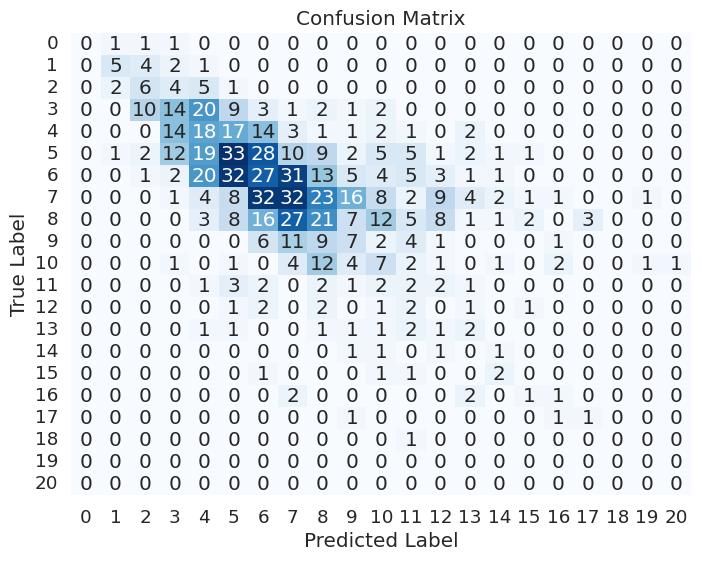

In [16]:
# Without pruning
print("Results of k-fold cross validation:")

# Define options
max_depth = None
min_samples_split = 2

# Calculate performance of implementation using an appropriate k-fold cross validation using confusion matrices on the given dataset
final_accuracy, accuracies_per_fold, final_cm = evaluate_decision_tree(X, y, translated_types, max_depth=max_depth, min_samples_split=min_samples_split)

print("Final Average Accuracy:", final_accuracy)
print("Accuracies per Fold:", accuracies_per_fold)
print("Confusion matrix:")
# print(final_cm)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **Comments:**

Splits the data into k folds using KFold.

For each fold:

*   Trains a decision tree classifier on the training data.

*  Evaluates the classifier on the test data.

*   Computes accuracy and confusion matrix for the fold.

*   Accumulates the accuracy scores and confusion matrices.

Calculates the final average accuracy across all folds.

Reads data from a CSV file (abalone.data).

Defines feature types (feature_types) and translates them into numeric values (translated_types).

*I translated them as 2 (categorical) and 1 (numercial) as written on the homework pdf.*

Evaluates decision tree classifier on the dataset.
Prints the final average accuracy, accuracy scores per fold, and displays the confusion matrix as a heatmap using seaborn.

# **Implementation of Decision Tree Testing Function with Pruning:**

Results of k-fold cross validation:
Final Average Accuracy: 0.22217574420536917
Accuracies per Fold: [0.13277511961722488, 0.2834928229665072, 0.2119760479041916, 0.2311377245508982, 0.25149700598802394]
Confusion matrix:


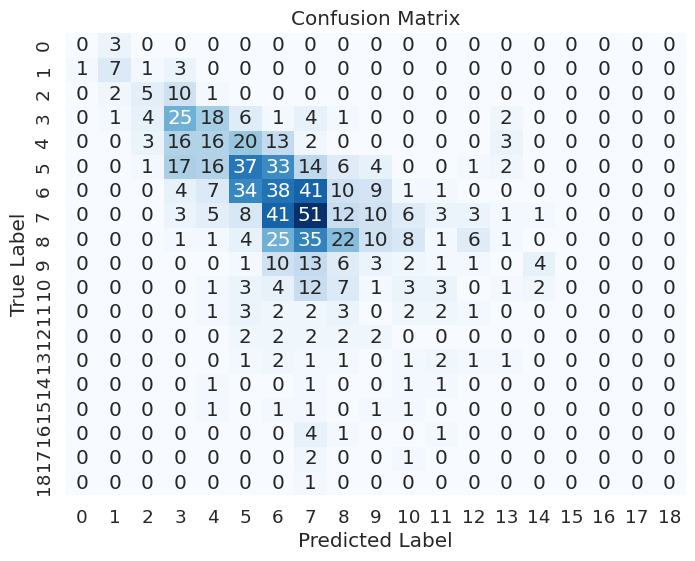

In [17]:
# With pre-pruning
print("Results of k-fold cross validation:")

# Define options
max_depth = 10
min_samples_split = 20

# Calculate performance of implementation using an appropriate k-fold cross validation using confusion matrices on the given dataset
final_accuracy, accuracies_per_fold, final_cm = evaluate_decision_tree(X, y, translated_types, max_depth=max_depth, min_samples_split=min_samples_split)

print("Final Average Accuracy:", final_accuracy)
print("Accuracies per Fold:", accuracies_per_fold)
print("Confusion matrix:")
# print(final_cm)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

I made pre-pruning using max_depth and min_samples_split. Accuracy has increased from 0.18 to 0.22.

# **Implementation of RDF:**

In [23]:

def build_rdf(X, y, attribute_types, N, max_depth, min_samples_split):
    trees = []

    # Build N trees
    for _ in range(N):
        # Random bootstrapping
        boot_indices = np.random.choice(np.arange(len(X)), size=len(X), replace=True)

        # feature_len = len(translated_types) - 1
        # print(len)

        # Random feature selection
        X_sample, y_sample = X[boot_indices], y[boot_indices]
        feature_indices = random.sample(range(8), k=int(np.sqrt(X.shape[1])))

        tree = build_dt(X_sample, y_sample, translated_types, max_depth, min_samples_split)
        trees.append((tree, feature_indices))
    return trees

def predict_rdf(rdf, X, options):
    predictions = []

    # Predict using each tree in the forest
    for index_X in X:
        votes = []

        # Make a prediction using each tree
        for tree, feature_indices in rdf:
            node = tree
            while isinstance(node, dict):

                # Ensure 'criteria' is valid with three elements
                if 'criteria' not in node or not isinstance(node['criteria'], tuple) or len(node['criteria']) != 3:
                    raise ValueError("Invalid or missing 'criteria' in node dictionary.")

                feature_index, split_value, feature_type = node['criteria'] # Unpack the tuple

                # Handle both numeric and categorical features
                if feature_type == 1:  # Numeric feature
                    if index_X[feature_index] < split_value:
                        node = node['left']
                    else:
                        node = node['right']
                elif feature_type == 2:  # Categorical feature
                    if index_X[feature_index] == split_value:
                        node = node['left']
                    else:
                        node = node['right']
                else:
                    raise ValueError("Feature type must be 1 (numeric) or 2 (categorical)")

            votes.append(node)  # When we reach a leaf node

        # Majority vote
        predictions.append(max(set(votes), key=votes.count))
    return np.array(predictions)



# **Implementation of RDF Testing Function:**

In [19]:

def evaluate_random_decision_forest(X, y, attribute_types, N, options, n_splits=5, max_depth=None, min_samples_split=2):
    kf = KFold(n_splits=n_splits)
    accuracy_scores = []

    # Initialize the initial confusion matrix
    final_cm = np.zeros((np.max(y)+1, np.max(y)+1), dtype=int)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Build the Random Decision Forest
        rdf = build_rdf(X_train, y_train, attribute_types, N, max_depth, min_samples_split)

        # Predict the labels on the test data
        y_pred = predict_rdf(rdf, X_test, options)

        # Calculate accuracy for the current fold
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        # Calculate confusion matrix for the current fold
        cm = confusion_matrix(y_test, y_pred)
        final_cm = np.zeros_like(cm)

        # Accumulate confusion matrix
        final_cm += cm

    # Calculate the final average accuracy across all folds
    final_accuracy = np.mean(accuracy_scores)

    return final_accuracy, accuracy_scores, final_cm



Results of k-fold cross validation:
Final Average Accuracy: 0.21188780334068708
Accuracies per Fold: [0.12440191387559808, 0.24401913875598086, 0.1844311377245509, 0.25389221556886227, 0.25269461077844313]
Confusion matrix:


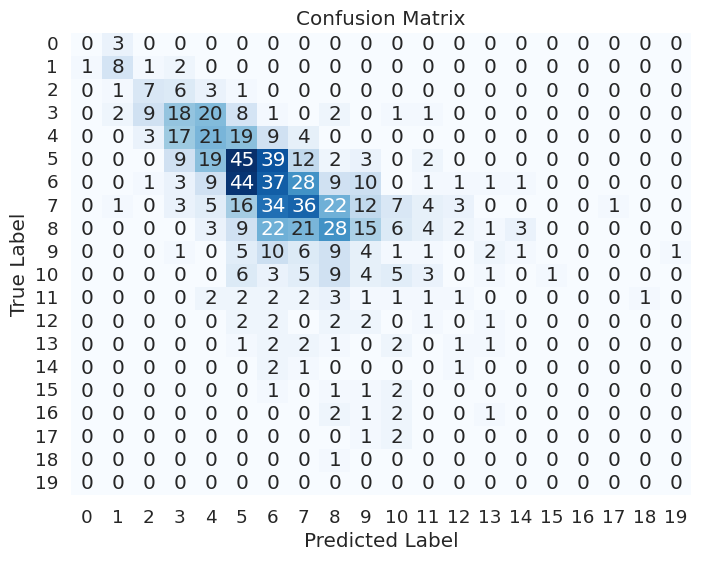

In [24]:
print("Results of k-fold cross validation:")

# Options
max_depth = 10
min_samples_split = 5
N = 5  # Number of trees in the forest

final_accuracy, accuracies_per_fold, final_cm = evaluate_random_decision_forest(X, y, translated_types, N, max_depth, min_samples_split)
print("Final Average Accuracy:", final_accuracy)
print("Accuracies per Fold:", accuracies_per_fold)
print("Confusion matrix:")
# print(final_cm)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **Comments:**

**build_rdf(X, y, attribute_types, N, max_depth, min_samples_split):** It constructs an RDF by creating a specified number (N) of decision trees.

For each tree:
*  It performs random bootstrapping to create a sample of the dataset.
*  It randomly selects a subset of features to use for splitting nodes in the decision tree.
*  It builds a decision tree (build_dt) using the sampled data and selected features.
*  It returns a list of tuples, where each tuple contains a decision tree and the indices of the features used for splitting.

**predict_rdf(rdf, X, options):** It predicts the labels for a given set of samples (X) using the RDF.

For each sample:

*  It traverses each decision tree in the RDF.
*  At each node of the tree, it follows the split based on the feature value of the sample.
*  It continues until it reaches a leaf node, which provides the prediction.
*  It collects the predictions from all trees and performs a majority vote to determine the final prediction.